# Signal Classification

訊號與圖的分類一樣，在preprocess後可使用神經網路做一些AI任務，例如訊號分類、迴歸還有生成等等。

這個部分我們用音訊作為訊號的範例，來試著將聲音訊號做分類，包含以下部分:
- Audio Data Loader
- RNN audio classification
- CNN audio classification

開始之前我們先準備一些內容。

我們使用的範例資料集是tensorflow提供的[Mini Speech Commands](https://ai.googleblog.com/2017/08/launching-speech-commands-dataset.html)資料集，從官網下載。

In [ ]:
!wget http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip
!unzip mini_speech_commands.zip

In [2]:
import librosa
import IPython.display as idp # 播音工具
import librosa.display as ldp # 畫頻譜圖工具
import numpy as np # 輔助運算
import matplotlib.pyplot as plt # 輔助畫圖

# import model用到的內容
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models

## Audio Data Loader

與前面CNN相同，需要有data loader去對資料做讀取，而tensorflow沒有原生讀音訊的data loader (TF 2.11有，但在Colab上要另外灌TF2.11)，所以這部分要自己寫。

### 讀取音訊檔

In [3]:
from glob import glob #拿來列資料夾內容的小套件

def find_class(x):
    # 根據格式，找到所屬class
    return x.strip('/')[-2]

def audio_folder_dataset( dataset_path,class_dictionary, sr=22050, duration=None):
    # 輸入: 
    ## dataset_path - 資料夾，內有數個不同class的資料夾，內有.wav檔
    ## class_dictionary - dictionary物件，對應每個資料夾的class
    ## sr -  讀取的sampling rate
    ## duration - 可指定秒數(float32)，不指定則為原檔長度
    file_names = []
    labels = []
    for cls, class_id in class_dictionary.items():
        f_list=glob(dataset_path+f'{cls}/*.wav') # 找到該class的所有檔案
        file_names.extend(f_list) # 加入列表
        labels.extend([class_id]*len(f_list)) # 加入相應labels
    print("total:",f"{len(file_names)} files of {len(class_dictionary)} classes")
    
    # 得到所有資料夾名稱
    path_ds = tf.data.Dataset.from_tensor_slices(file_names) # 轉換成檔名的Dataset物件

    label_ds= tf.data.Dataset.from_tensor_slices(labels)

    def load_wav(fname):
        # 使用指定sampling rate, duration讀檔
        # 會從binary格式轉成一般文字再開始做
        return librosa.load(fname.numpy(), sr=sr, duration=duration)
    def load_file(fname):
        # 使用
        return tf.py_function(func=load_wav, inp=[fname], Tout=tf.float32)
    data_ds=path_ds.map(
            load_file,
            num_parallel_calls=tf.data.AUTOTUNE,
        )
    return tf.data.Dataset.zip((data_ds,label_ds))

生成一個dataset拿來用作基礎。

In [12]:
# 準備一些參數輸入進function生成dataset
DATASET_PATH='mini_speech_commands/'
class_dict={
    'down':0,
    'go':1,
    'left':2,
    'no':3,
    'right':4,
    'stop':5,
    'up':6,
    'yes':7
}
SR=22050
DURATION=0.8
dataset=audio_folder_dataset(DATASET_PATH,
                             class_dict,
                             sr=SR,
                             duration=DURATION)

total: 8000 files of 8 classes


觀察data基本性質，一次丟出一個signal以及一個label

In [19]:
for x,y in dataset:
    print(x.shape,x.numpy().min(),x.numpy().max())
    print(y)
    break

(17640,) -0.556663 0.26991862
tf.Tensor(0, shape=(), dtype=int32)


畫出一個例子

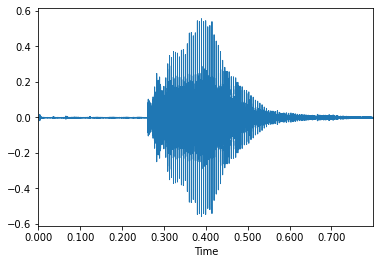

In [20]:
ldp.waveplot(x.numpy(),sr=SR)

### 輸入NN前做轉換

In [23]:
def get_stft(waveform):
  # 做STFT (用tensorflow得比較快)
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # 若是多加一個維度，可以用於CNN，shape (`batch_size`, `height`, `width`, `channels`).
  # spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [25]:
dataset= dataset.map(lambda x,y: (get_stft(x), y), num_parallel_calls=tf.data.AUTOTUNE)

In [26]:
for x,y in dataset:
    print(x.shape,x.numpy().min(),x.numpy().max())
    print(y)
    break

(136, 129) 0.0 8.207278
tf.Tensor(0, shape=(), dtype=int32)
